<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-3CLS/blob/No-Building/Kaggle_3CLS_No_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip uninstall jax -y

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26


In [3]:
!pip install tensorflow==2.15.0

In [4]:
!python --version

Python 3.10.12


In [5]:
!pip install image_to_numpy==1.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for image_to_numpy: filename=image_to_numpy-1.0.0-py3-none-any.whl size=3456 sha256=99b437fa6c2377d693b31a2109795c57322b5a61aa93ce4a792878ec849812b6
  Stored in directory: /root/.cache/pip/wheels/4c/e5/7e/f10f47129bb75abc8cd52a8abbff926b4a6121990f926cfe6d
Successfully built image_to_numpy


In [6]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=7976c2f37325128a0a3159bfece61d8ea13bac4232fbf2321b505648d0fb253b
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [28]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=384,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=3, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=15,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [13]:
with tf.device('/gpu:0'):
    labels = ['Plant', 'Vehicle', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [14]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [15]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

plants_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
total_test_idx = np.concatenate((plants_test_idx, vehicles_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [16]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [17]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [18]:
!mkdir MODEL

In [19]:
!ls ./

drive  MODEL  sample_data


In [30]:
model_name= 'Model 3CLS-NB-4.1.3'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-3Cls-No-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/6e774d93-d3cc-4e6b-8433-27a14ab698de
Epoch 1/55
158/158 [==============================] - ETA: 0s - loss: 8.1571 - accuracy: 0.7198
Epoch 1: val_loss improved from inf to 5.37322, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-0
158/158 [==============================] - 9s 32ms/step - loss: 8.1571 - accuracy: 0.7198 - val_loss: 5.3732 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 1.2263 - accuracy: 0.8117
Epoch 2: val_loss improved from 5.37322 to 2.90556, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-0
158/158 [==============================] - 5s 30ms/step - loss: 1.2278 - accuracy: 0.8111 - val_loss: 2.9056 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 3/55
156/158 [============================>.] - ETA: 0s - loss: 0.5114 - accuracy: 0.8518
Epoch 3: val_loss improved from 2.90556 to 0.85510, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/

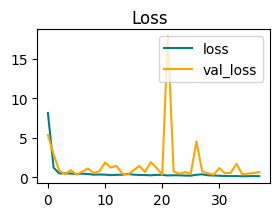

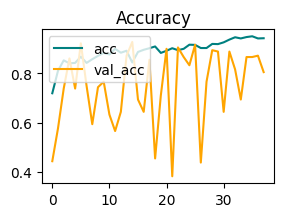

Fold Training Time: 0 hour(s) and 1 mins
Precision: 94.0119743347168  -  Recall: 87.22222447395325
Accuracy: 92.77777671813965
F1Score-P: 95.08197021484375
F1Score-R: 92.98246002197266
F1Score-V: 90.32257843017578
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/5786e09e-4517-4021-a16b-3cb42e13065b
Epoch 1/55
155/158 [============================>.] - ETA: 0s - loss: 8.9613 - accuracy: 0.7226
Epoch 1: val_loss improved from inf to 23.49185, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-1
158/158 [==============================] - 8s 31ms/step - loss: 8.8412 - accuracy: 0.7262 - val_loss: 23.4918 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/55
155/158 [============================>.] - ETA: 0s - loss: 1.1486 - accuracy: 0.8113
Epoch 2: val_loss improved from 23.49185 to 3.32166, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-1
158/158 [=================

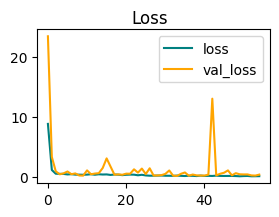

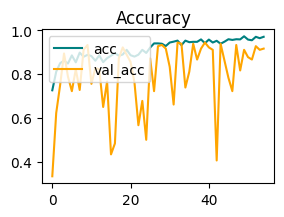

Fold Training Time: 0 hour(s) and 2 mins
Precision: 95.4285740852356  -  Recall: 92.77777671813965
Accuracy: 93.88889074325562
F1Score-P: 93.75
F1Score-R: 89.90825653076172
F1Score-V: 97.56097412109375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/142e3303-17cd-42a8-8155-85c30413fdd9
Epoch 1/55
156/158 [============================>.] - ETA: 0s - loss: 7.6915 - accuracy: 0.6915
Epoch 1: val_loss improved from inf to 5.10087, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-2
158/158 [==============================] - 8s 31ms/step - loss: 7.6472 - accuracy: 0.6921 - val_loss: 5.1009 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 2/55
155/158 [============================>.] - ETA: 0s - loss: 1.0112 - accuracy: 0.8218
Epoch 2: val_loss improved from 5.10087 to 2.42991, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-2
158/158 [==============================] 

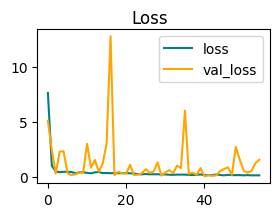

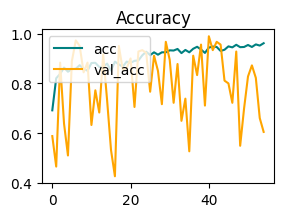

Fold Training Time: 0 hour(s) and 2 mins
Precision: 99.43820238113403  -  Recall: 98.33333492279053
Accuracy: 98.88888597488403
F1Score-P: 99.17355346679688
F1Score-R: 98.33333587646484
F1Score-V: 99.15966033935547
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/0351a317-5a50-40a8-8f66-a5f42d17edb8
Epoch 1/55
156/158 [============================>.] - ETA: 0s - loss: 7.8403 - accuracy: 0.7316
Epoch 1: val_loss improved from inf to 3.96786, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-3
158/158 [==============================] - 8s 32ms/step - loss: 7.7695 - accuracy: 0.7333 - val_loss: 3.9679 - val_accuracy: 0.5944 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 0.7908 - accuracy: 0.8045
Epoch 2: val_loss improved from 3.96786 to 0.98293, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-3
158/158 [===================

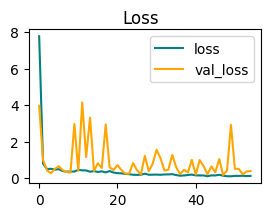

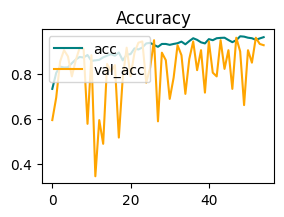

Fold Training Time: 0 hour(s) and 2 mins
Precision: 97.17513918876648  -  Recall: 95.55555582046509
Accuracy: 96.11111283302307
F1Score-P: 94.82758331298828
F1Score-R: 94.4000015258789
F1Score-V: 99.15966033935547
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f7b4371e-2ff4-43bf-b4a2-480f4ec5c622
Epoch 1/55
156/158 [============================>.] - ETA: 0s - loss: 7.2968 - accuracy: 0.7155
Epoch 1: val_loss improved from inf to 2.99532, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-4
158/158 [==============================] - 8s 31ms/step - loss: 7.2413 - accuracy: 0.7159 - val_loss: 2.9953 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 0.8886 - accuracy: 0.8077
Epoch 2: val_loss improved from 2.99532 to 2.20918, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-4
158/158 [====================

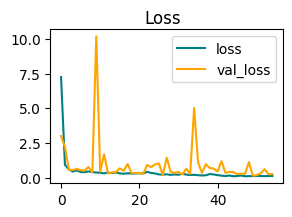

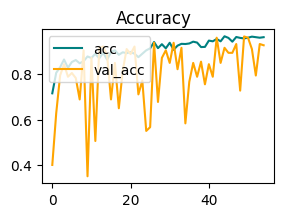

Fold Training Time: 0 hour(s) and 2 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-P: 94.82758331298828
F1Score-R: 96.72130584716797
F1Score-V: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/d84a811b-b599-4a29-9d81-137250826a05
Epoch 1/55
156/158 [============================>.] - ETA: 0s - loss: 7.0115 - accuracy: 0.7011
Epoch 1: val_loss improved from inf to 7.30648, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-5
158/158 [==============================] - 8s 31ms/step - loss: 6.9545 - accuracy: 0.7024 - val_loss: 7.3065 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 1.0485 - accuracy: 0.8245
Epoch 2: val_loss improved from 7.30648 to 1.63926, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-5
158/158 [===================

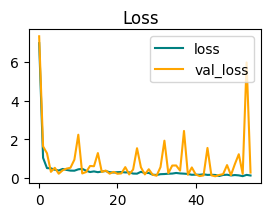

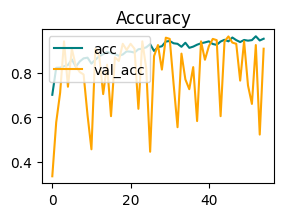

Fold Training Time: 0 hour(s) and 2 mins
Precision: 97.20670580863953  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-P: 97.56097412109375
F1Score-R: 94.7368392944336
F1Score-V: 97.56097412109375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/3ac492b7-8dac-4038-bb13-5adaec33b6b9
Epoch 1/55
155/158 [============================>.] - ETA: 0s - loss: 9.6846 - accuracy: 0.7040
Epoch 1: val_loss improved from inf to 6.76135, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-6
158/158 [==============================] - 8s 31ms/step - loss: 9.5466 - accuracy: 0.7063 - val_loss: 6.7614 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 0.8546 - accuracy: 0.8245
Epoch 2: val_loss improved from 6.76135 to 1.25488, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-6
158/158 [====================

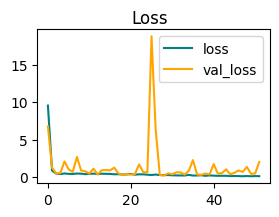

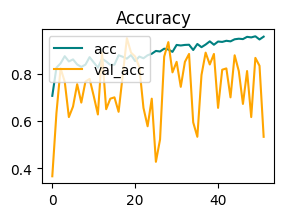

Fold Training Time: 0 hour(s) and 2 mins
Precision: 99.38271641731262  -  Recall: 89.4444465637207
Accuracy: 93.33333373069763
F1Score-P: 91.47286224365234
F1Score-R: 92.03539276123047
F1Score-V: 96.61016845703125
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/24442119-be2b-477b-bfc9-7711372f937c
Epoch 1/55
155/158 [============================>.] - ETA: 0s - loss: 7.7693 - accuracy: 0.7242
Epoch 1: val_loss improved from inf to 4.02595, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-7
158/158 [==============================] - 8s 31ms/step - loss: 7.7027 - accuracy: 0.7238 - val_loss: 4.0259 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 2/55
156/158 [============================>.] - ETA: 0s - loss: 1.3543 - accuracy: 0.8285
Epoch 2: val_loss improved from 4.02595 to 1.39449, saving model to /content/MODEL/Model 3CLS-NB-4.1.3/FOLD-7
158/158 [====================

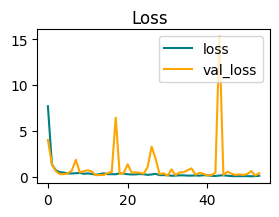

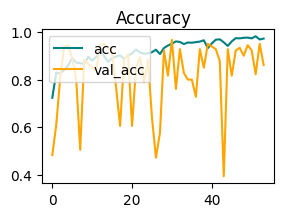

Fold Training Time: 0 hour(s) and 2 mins
Precision: 96.61017060279846  -  Recall: 94.9999988079071
Accuracy: 96.66666388511658
F1Score-P: 96.72130584716797
F1Score-R: 96.72130584716797
F1Score-V: 96.55171966552734
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 18 mins


In [31]:
params = {
    "lr": 0.001,
    "epochs": 55,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_plant = []
f1_road = []
f1_vcl = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_plant.append(f1_s[0])
        f1_vcl.append(f1_s[1])
        f1_road.append(f1_s[2])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-P"] = f1_plant[counter]
        run["eval/F1-R"] = f1_road[counter]
        run["eval/F1-V"] = f1_vcl[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-P: {f1_plant[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')
        print(f'F1Score-V: {f1_vcl[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [32]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-P: {avg_rate(f1_plant)}
Avg F1-Score-R: {avg_rate(f1_road)}
Avg F1-Score-V: {avg_rate(f1_vcl)}
""")


Avg Accuracy: 95.62499895691872
Avg Precision: 96.99001833796501
Avg Recall: 93.95833313465118
Avg F1-Score-P: 95.4269790649414
Avg F1-Score-R: 94.47986221313477
Avg F1-Score-V: 96.91079807281494



In [33]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-P"] = avg_rate(f1_plant)
run["eval/F1-R"] = avg_rate(f1_road)
run["eval/F1-V"] = avg_rate(f1_vcl)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/c1ecdb95-aeb1-4e14-9202-c624b1d9eb39
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [34]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [35]:
!neptune sync -p 'New-Thesis/Kaggle-3Cls-No-Building' --offline-only


Offline container 9bd5c75e-93ab-410a-9b90-ca26265f2d1b registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-34
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-34
Deleted: /content/.neptune/async/run__9bd5c75e-93ab-410a-9b90-ca26265f2d1b__52124__mb0mqmtm
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-34 completed.
Offline container 9bd5c778-564d-442b-abf2-13faa9c7b116 registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-35
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-35
Deleted: /content/.neptune/async/run__9bd5c778-564d-442b-abf2-13faa9c7b116__52124__a3obeeev
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-35 completed.
Offline container 9bd5c786-8034-47cb-bfaa-fe8d2f90626f registered as New-Thesis/Kaggle-3Cls-No-Building/K3NB-36
Synchronising New-Thesis/Kaggle-3Cls-No-Building/K3NB-36
Deleted: /content/.neptune/async/run__9bd5c786-8034-47cb-bfaa-fe8d2f90626f__52124__6e1y95h6
Synchronization of run New-Thesis/Kaggle-3Cls-No-Building/K3NB-

In [36]:
!neptune clear


In [37]:
!rm -r "/content/MODEL/Model 3CLS-NB-4.1.3"

## Extract Model Checkpoint
- Download model from neptune AI
- Upload here
- change path and names and run code

In [ ]:
sm = tf.keras.models.load_model("/content/model.keras")


In [ ]:
FIX-MODEL-NAME

sm.save_weights("./checkpoints/test_model")


In [ ]:
!zip -r test.zip "./checkpoints"